In [7]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
# from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm


In [8]:
!nvidia-smi

Tue Nov 14 17:20:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        # boundary GREEN color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.read_mask(label_path)  # Đọc nhãn dưới dạng BGR
        image = cv2.resize(image, self.resize)
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']
        return image, label
    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [10]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    # iterate over 1000 images
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

1000

In [11]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    #iterate over 1000 masks
    for file in files:
        # obtain the path"
        path = os.path.join(root,file)
        # add path to the list
        mask_path.append(path)
len(mask_path)

1000

In [12]:
trainsize = 384
batch_size = 8

dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (trainsize,trainsize),
                             transform = None)

In [13]:
total_size = len(dataset)
train_size = int(total_size * 0.9)
valid_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

In [14]:
class CustomDataset(CustomImageDataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index] 
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image']
            label = transformed['mask']
            label = label.permute(2,0,1)
        return image, label

    def __len__(self):
        return len(self.dataset)

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.Cutout(p=0.2, max_h_size=35, max_w_size=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.RandomCrop(384, 384),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset_not_aug = CustomDataset(train_dataset,
                             transform = val_transform)
train_dataset_aug = CustomDataset(train_dataset,
                             transform = train_transform)
val_dataset = CustomDataset(val_dataset,
                             transform = val_transform)

train_dataset_new = ConcatDataset([train_dataset_not_aug, train_dataset_aug])

train_loader = DataLoader(train_dataset_new, batch_size= batch_size, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle= False)
print(len(train_dataset_new))

1800


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Image:  torch.Size([3, 384, 384]) Label:  torch.Size([1, 384, 384])


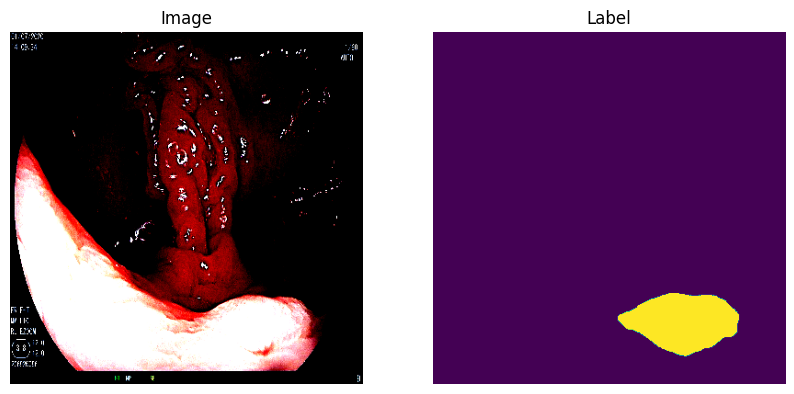

In [15]:
image,label = train_dataset_new[0]
print('Image: ', image.shape, 'Label: ', label.shape)

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, bottle_neck = False):
        super(DoubleConv, self).__init__() 
        self.double_conv = nn. Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        if bottle_neck == True:
            self.double_conv = nn. Sequential(
                nn.Conv2d(in_channels, out_channels*2, kernel_size=3, padding=1), 
                nn.BatchNorm2d(out_channels*2),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class DownBlock (nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels) 
        self.down_sample = nn.MaxPool2d(2)
        
    def forward(self, x):
        skip_out = self.double_conv(x) 
        down_out = self.down_sample(skip_out) 
        return (down_out, skip_out)
class UpBlock (nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            if out_channels*4 == in_channels:
                self.up_sample= nn.ConvTranspose2d(in_channels-out_channels*2, in_channels-out_channels*2, kernel_size=2, stride=2)
            else:
                self.up_sample= nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2) 
        else:
            self.up_sample= nn.Upsample (scale_factor=2, mode='bilinear', align_corners=True)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1) 
        return self.double_conv(x)

In [17]:
class PolypModel(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super().__init__()
        self.out_classes = out_classes
        self.encoder = timm.create_model("resnet152", pretrained=True, features_only=True)
#         self.down_conv1 = DownBlock(3, 64) 
        self.down_conv1 = DownBlock(64, 128) 
        self.down_conv2 = DownBlock(256, 512) 
        self.down_conv3 = DownBlock (512, 1024) 
        self.down_conv4 = DownBlock (1024, 2048) 
        self.up_sample_mode = up_sample_mode
        self.block_neck = DoubleConv(2048, 1024)
        self.block_up1 = UpBlock (1024+1024, 512, self.up_sample_mode) 
        self.block_up2 = UpBlock (512+512, 256, self.up_sample_mode) 
        self.block_up3 = UpBlock (256+256, 128, self.up_sample_mode) 
        self.block_up4 = UpBlock(128+64, 64, self.up_sample_mode) 
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1) 
        self.upsample = nn.Upsample (scale_factor=2, mode="bilinear")
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)
        x = self.block_neck(x5)
        x = self.block_up1(x, x4)
        x = self.block_up2(x, x3)
        x = self.block_up3(x, x2) 
        x = self.block_up4(x, x1)
        x = self.conv_last(x)
        x = self.upsample(x) 
        return x

In [18]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))
#     print(output.shape)
    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [19]:
torch.cuda.empty_cache()
model = PolypModel(3)


In [20]:
# Define the optimizer (e.g., Adam optimizer)
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
!pip install wandb
!wandb login 'af3fff39f107c47a5441bad9ba81d9c46a34914b'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
import wandb
wandb.login()


wandb: Currently logged in as: hoangdungit510 (hdd0510). Use `wandb login --relogin` to force relogin


True

In [25]:
wandb.init(
    project = 'Polyp',
    config = {
        'learning_rate': 0.0001,
        'architecture': 'Unet',
        'dataset': 'Polyp',
        'epoch': 300
    }
)

Loss,0.1098072334


In [26]:
# Set the number of training epochs
num_epochs = 200

# Move the model to the device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
train_loss_array = []
best_val_loss = 999
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        labels = labels.squeeze(dim=1).long()

        outputs = model(images)

        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()  # Accumulate the loss
    train_loss = total_loss / len(train_loader)

        
# Perform validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()

            # Forward pass
            outputs = model(images)
            val_loss += criterion(outputs.float(),labels.long()).item()

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], val_loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('SAVE +1')
    # Calculate average loss for the epoch
    
    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss
              })


Epoch [1/125], Loss: 0.0853539909
SAVE +1
Epoch [2/125], Loss: 0.0557338065
SAVE +1
Epoch [3/125], Loss: 0.0506207344
SAVE +1


KeyboardInterrupt: 

In [ ]:
# checkpoint = torch.load('/kaggle/input/checkpointunet/unet.pth')
# model.load_state_dict(checkpoint['model'])
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Thay đổi các tham số theo cấu hình của bạn

# # Nạp trạng thái của optimizer từ checkpoint
# optimizer.load_state_dict(checkpoint['optimizer'])

# # Sau khi nạp trạng thái, đưa cả model và optimizer lên device
# model.to(device)
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.to(device)
# loss_value = checkpoint['loss']

# # Move the loss tensor to the appropriate device
# # loss_tensor = loss_tensor.to(device)

# # If you need to use the loss as a Python scalar, for example for printing or comparisons:
# # loss_value = loss_tensor.item()

# # Now you can print or compare `loss_value` as needed
# print(f"The loss from the checkpoint is: {loss_value:.10f}")

In [ ]:
# !mkdir -p /kaggle/working/colorization_model
# !mv /kaggle/working/colorization_model.pth /kaggle/working/colorization_model  # Move the file into the folder for the dataset
# !kaggle datasets init -p /kaggle/working/colorization_model

# # Manually edit the dataset-metadata.json file here to include your dataset's metadata

# # After editing the JSON, create or update the dataset on Kaggle
# !kaggle datasets create -p /kaggle/working/colorization_model -u

In [ ]:
!mkdir test_mask
!mkdir test_overlapmask

In [ ]:
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    new_rgb_mask = np.zeros((*mask.shape, 3)).astype(np.uint8)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb_true = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    overlap = 0.7*ori_img+0.3*mask_rgb_true
    overlap = overlap.astype('uint8')
    overlap = cv2.cvtColor(overlap, cv2.COLOR_RGB2BGR)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("test_mask/{}".format(i), mask_rgb)
    cv2.imwrite("test_overlapmask/{}".format(i), overlap)
    print("processed ", img_path)
     

In [ ]:
%%sh
killall5 -9

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/test_mask' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)